---
title: Time Steppers with Diffrax
suptitle: Diffraxing
short_title: Time Step
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

+++ {"part": "abstract"}

We introduce....

+++

**Citation**

follow the FORCE11 recommendations [hi](doi:10.4230/DAGMAN.1.1.41). Specifically:

## Time Stepping

In [49]:
import functools as ft

In [50]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain


num_minutes = 30
dt = pd.to_timedelta(num_minutes, unit="minutes").total_seconds()
debug = False
num_days = 5
tmin = 0.0
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()

num_hours_save = 1
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

print(f"Step Size (dt): {int(dt/60)} minutes")
print(f"Tmax: {num_days} days")
print(f"Tmax: {tmax:,} seconds | {int(tmax/60/60/24)} day(s)")

Step Size (dt): 30 minutes
Tmax: 5 days
Tmax: 432,000.0 seconds | 5 day(s)


In [51]:
ts = np.arange(tmin, tmax + dt, dt)

step = ft.partial(QG.equation_of_motion, t=0, args=params)


if not debug:
    step = jax.jit(step)

In [52]:
from tqdm.autonotebook import tqdm

state, params = State.init_state(ds.ssh[0], c1=c1)


ssh_0 = QG.ssh_from_state(state, params, axis=-1)
ssh_0.min(), ssh_0.max()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_11314/1426551605.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


(Array(-0.38488853, dtype=float64), Array(1.16310116, dtype=float64))

In [53]:
q = state.q

for iteration in tqdm(ts):
    # SPATIAL DISCRETIZATION

    # right hand side
    state = step(state=state)

    q_rhs = state.q

    q = q + dt * q_rhs

    state = State.update_state(state, q=q)


q.min(), q.max()

  0%|          | 0/241 [00:00<?, ?it/s]

(Array(-0.00045287, dtype=float64), Array(0.00016476, dtype=float64))

In [54]:
ssh_t = QG.ssh_from_state(state, params, axis=-1)

ssh_t.min(), ssh_t.max()

(Array(-0.34287322, dtype=float64), Array(1.16310116, dtype=float64))

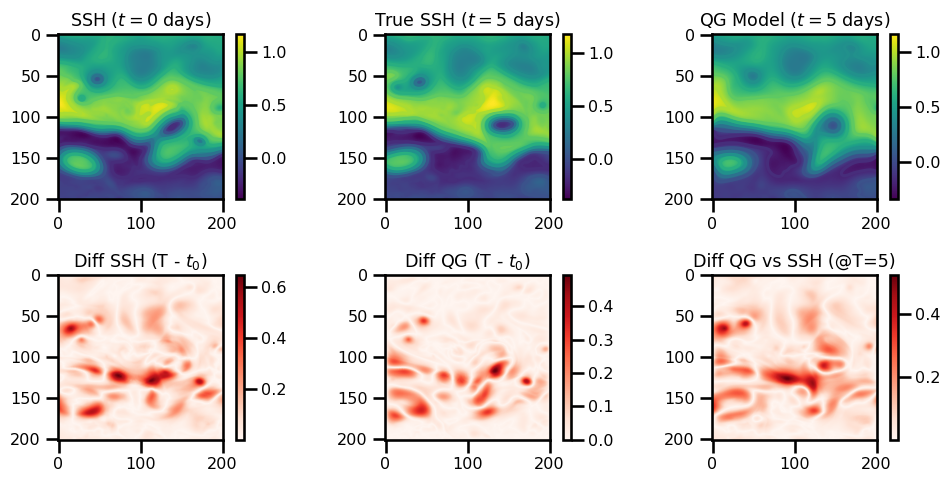

In [57]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))

#
ax[0, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 0].set(title=f"SSH ($t=0$ days)")
ax[0, 1].contour(ds.ssh[num_days].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[num_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 1].set(title=f"True SSH ($t={num_days}$ days)")

ax[0, 2].contour(ssh_t.T, cmap="viridis")
pts = ax[0, 2].imshow(ssh_t.T, cmap="viridis")
ax[0, 2].set(title=f"QG Model ($t={num_days}$ days)")
plt.colorbar(pts)


pts = ax[1, 0].imshow(np.abs(ds.ssh[0].values - ds.ssh[num_days].values), cmap="Reds")
plt.colorbar(pts)
ax[1, 0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1, 1].imshow(np.abs(ds.ssh[0].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1, 2].imshow(np.abs(ds.ssh[num_days].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 2].set(title=f"Diff QG vs SSH (@T={num_days})")


plt.tight_layout()
plt.show()

## Time Stepping w/ Diffrax (Step-by-Step)

In [59]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain


num_minutes = 30
dt = pd.to_timedelta(num_minutes, unit="minutes").total_seconds()
debug = False
num_days = 5
tmin = 0.0
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()

num_hours_save = 1
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

print(f"Step Size (dt): {int(dt/60)} minutes")
print(f"Tmax: {num_days} days")
print(f"Tmax: {tmax:,} seconds | {int(tmax/60/60/24)} day(s)")

Step Size (dt): 30 minutes
Tmax: 5 days
Tmax: 432,000.0 seconds | 5 day(s)


In [60]:
ts = jnp.arange(tmin, tmax, dt)
ts.min(), ts.max(), ts.shape

(Array(0., dtype=float64), Array(430200., dtype=float64), (240,))

In [61]:
solver = dfx.Euler()  # dfx.Tsit5() #dfx.Dopri5() #

In [62]:
state, params = State.init_state(ds.ssh[0], c1=c1)

solver_state = solver.init(
    terms=dfx.ODETerm(QG.equation_of_motion),
    t0=tmax,
    t1=tmin + dt,
    y0=state,
    args=params,
)

In [63]:
with tqdm(ts) as pbar:
    for t in pbar:
        state, _, _, solver_state, _ = solver.step(
            terms=dfx.ODETerm(QG.equation_of_motion),
            t0=t,
            t1=t + dt,
            y0=state,
            args=params,
            solver_state=solver_state,
            made_jump=False,
        )
        ssh_t = QG.ssh_from_state(state, params, axis=-1)
        pbar.set_description(f"ssh: {ssh_t.min():.4f}, {ssh_t.max():.4f}")

  0%|          | 0/240 [00:00<?, ?it/s]

In [64]:
ssh_t = QG.ssh_from_state(state, params, axis=-1)

ssh_0.min(), ssh_0.max(), ssh_t.min(), ssh_t.max()

(Array(-0.38488853, dtype=float64),
 Array(1.16310116, dtype=float64),
 Array(-0.3429521, dtype=float64),
 Array(1.16310116, dtype=float64))

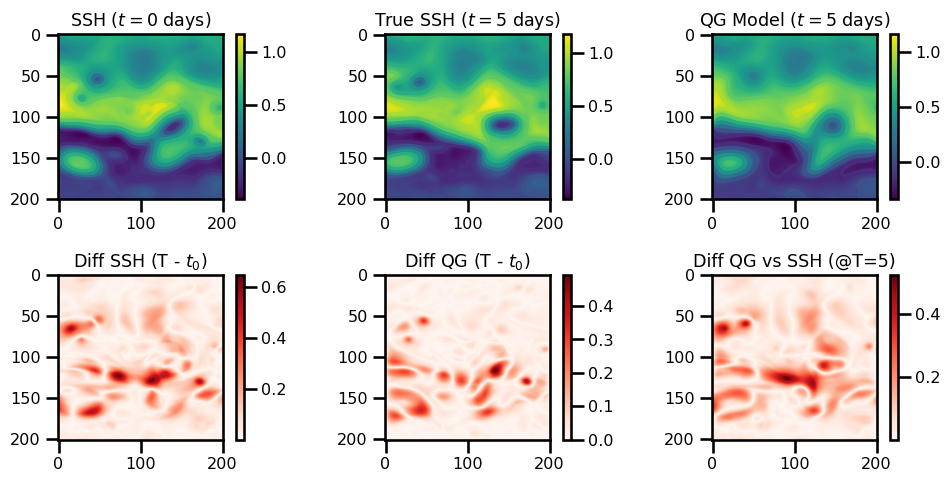

In [67]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))

#
ax[0, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 0].set(title=f"SSH ($t=0$ days)")
ax[0, 1].contour(ds.ssh[num_days].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[num_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 1].set(title=f"True SSH ($t={num_days}$ days)")

ax[0, 2].contour(ssh_t.T, cmap="viridis")
pts = ax[0, 2].imshow(ssh_t.T, cmap="viridis")
ax[0, 2].set(title=f"QG Model ($t={num_days}$ days)")
plt.colorbar(pts)


pts = ax[1, 0].imshow(np.abs(ds.ssh[0].values - ds.ssh[num_days].values), cmap="Reds")
plt.colorbar(pts)
ax[1, 0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1, 1].imshow(np.abs(ds.ssh[0].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1, 2].imshow(np.abs(ds.ssh[num_days].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 2].set(title=f"Diff QG vs SSH (@T={num_days})")


plt.tight_layout()
plt.show()

## Time Stepping with Diffrax (All together)

In [68]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain


num_minutes = 30
dt = pd.to_timedelta(num_minutes, unit="minutes").total_seconds()
debug = False
num_days = 5
tmin = 0.0
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()

num_hours_save = 1
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

print(f"Step Size (dt): {int(dt/60)} minutes")
print(f"Tmax: {num_days} days")
print(f"Tmax: {tmax:,} seconds | {int(tmax/60/60/24)} day(s)")

Step Size (dt): 30 minutes
Tmax: 5 days
Tmax: 432,000.0 seconds | 5 day(s)


In [69]:
# time domain
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)


t_domain

TimeDomain(tmin=0.0, tmax=432000.0, dt=1800.0)

In [70]:
num_hours_save = 6
dt_save = pd.to_timedelta(num_hours_save, unit="hours").total_seconds()

ts = jnp.arange(tmin, tmax, dt_save)
saveat = dfx.SaveAt(ts=ts)

In [71]:
# SPATIAL DISCRETIZATION
# initialize state
solver = dfx.Euler()
# max_steps = 10
# DYNAMICAL SYSTEM
dyn_model = QG(t_domain=t_domain, saveat=saveat, solver=solver)

In [72]:
%%time

state_init, params = State.init_state(ds.ssh[0], c1=c1)

state_sol = dyn_model.integrate(state_init, dt, params, max_steps=10_000)

CPU times: user 4.73 s, sys: 88.1 ms, total: 4.82 s
Wall time: 4.75 s


In [73]:
state_sol.q.shape

(20, 201, 201)

In [74]:
ssh_t = QG.ssh_from_state(state_sol, params, axis=-1)

ssh_t.min(), ssh_t.max()

(Array(-0.34345551, dtype=float64), Array(1.16310116, dtype=float64))

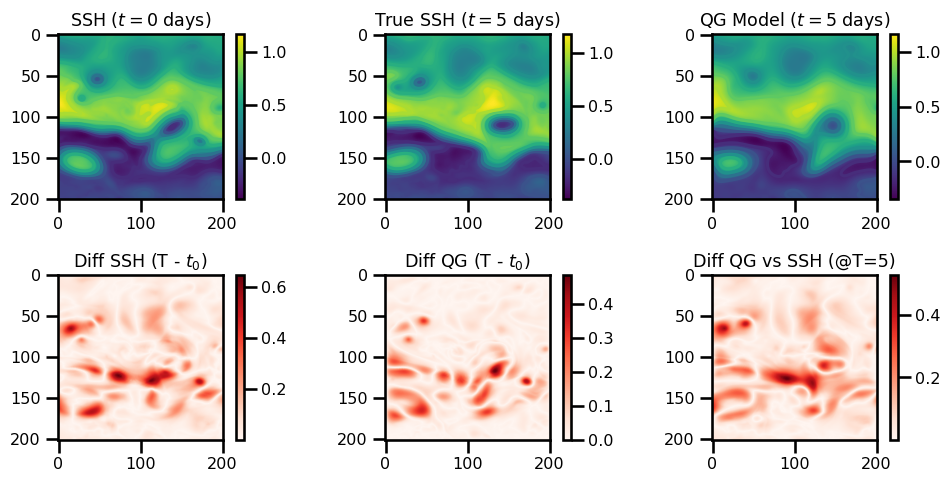

In [75]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))

#
ax[0, 0].contour(ds.ssh[0].values, cmap="viridis")
pts = ax[0, 0].imshow(ds.ssh[0].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 0].set(title=f"SSH ($t=0$ days)")
ax[0, 1].contour(ds.ssh[num_days].values, cmap="viridis")
pts = ax[0, 1].imshow(ds.ssh[num_days].values, cmap="viridis")
plt.colorbar(pts)
ax[0, 1].set(title=f"True SSH ($t={num_days}$ days)")

ax[0, 2].contour(ssh_t.T, cmap="viridis")
pts = ax[0, 2].imshow(ssh_t.T, cmap="viridis")
ax[0, 2].set(title=f"QG Model ($t={num_days}$ days)")
plt.colorbar(pts)


pts = ax[1, 0].imshow(np.abs(ds.ssh[0].values - ds.ssh[num_days].values), cmap="Reds")
plt.colorbar(pts)
ax[1, 0].set(title=f"Diff SSH (T - $t_0$)")

pts = ax[1, 1].imshow(np.abs(ds.ssh[0].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 1].set(title=f"Diff QG (T - $t_0$)")


pts = ax[1, 2].imshow(np.abs(ds.ssh[num_days].values - ssh_t.T), cmap="Reds")
plt.colorbar(pts)
ax[1, 2].set(title=f"Diff QG vs SSH (@T={num_days})")


plt.tight_layout()
plt.show()